In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [0]:
os.chdir('/content/drive/My Drive/108-2 Machine Learning/02 Midterm Assignments /02 Classification_Admission Rate of FCU Math')

### Feature Extraction
1. Split 申請系所 into multiple columns
2. Find 考區 state  


In [0]:
train = pd.read_csv('01 Data/train.csv')
train.head()

,考區,申請系所,FCU,FCU_AM
0,國立中興高中,逢甲大學應用數學系\n東海大學應用數學系,0,0
1,國立虎尾高中,逢甲大學應用數學系\n中原大學應用數學系\n東海大學統計學系(自然組)\n逢甲大學環境工程與...,1,0
2,高雄市立左營高中,逢甲大學應用數學系\n靜宜大學生態人文學系-類繁星\n靜宜大學化粧品科學系-類繁星\n長榮大...,0,0
3,國立台南二中,逢甲大學應用數學系\n逢甲大學統計學系,1,1
4,國立臺中二中,逢甲大學應用數學系\n東吳大學數學系\n逢甲大學統計學系\n逢甲大學資訊電機學院不分系榮譽班...,1,1


In [0]:
''' Deal with duplicates in data ''' 
train.drop_duplicates(subset=['考區', '申請系所', 'FCU', 'FCU_AM'], keep='first', inplace=True)
train.shape

(878, 4)

In [0]:
''' Missing values '''
train[train.isnull().values]
train.drop(826, axis=0, inplace=True)

In [0]:
''' No. of universities applied ''' 
uni_list = train['申請系所'].str.split('\n')
print('The max no. of uni is ' + str(max(uni_list.str.len()))) #max = 11
train['total_uni'] = [round(uni) for uni in uni_list.str.len()]

for i in range(11):
  colname = 'uni_' + str(i)
  train[colname] = 0

for index, value in uni_list.items():
  for n in range(train.loc[index,'total_uni']):
    train.loc[index, 'uni_' + str(n)] = value[n]
train.head(3)

The max no. of uni is 11


,考區,申請系所,FCU,FCU_AM,total_uni,uni_0,uni_1,uni_2,uni_3,uni_4,uni_5,uni_6,uni_7,uni_8,uni_9,uni_10
0,國立中興高中,逢甲大學應用數學系\n東海大學應用數學系,0,0,2,逢甲大學應用數學系,東海大學應用數學系,0,0,0,0,0,0,0,0,0
1,國立虎尾高中,逢甲大學應用數學系\n中原大學應用數學系\n東海大學統計學系(自然組)\n逢甲大學環境工程與...,1,0,4,逢甲大學應用數學系,中原大學應用數學系,東海大學統計學系(自然組),逢甲大學環境工程與科學學系,0,0,0,0,0,0,0
2,高雄市立左營高中,逢甲大學應用數學系\n靜宜大學生態人文學系-類繁星\n靜宜大學化粧品科學系-類繁星\n長榮大...,0,0,4,逢甲大學應用數學系,靜宜大學生態人文學系-類繁星,靜宜大學化粧品科學系-類繁星,長榮大學保健營養學系,0,0,0,0,0,0,0


In [0]:
''' Create high school location column '''
''' https://depart.moe.edu.tw/ed4500/News_Content.aspx?n=63F5AB3D02A8BBAC&sms=1FF9979D10DBF9F3&s=BF61A0C5E5432A0B '''

df_hs = pd.read_csv("01 Data/high.csv")
df_hs = df_hs.iloc[:, [1,3]] #取 [學校名稱]、[縣市名稱]
df_hs['縣市名稱'] = [i[1] for i in df_hs['縣市名稱'].str.split(']')]
df_hs.columns = ['hs', 'hs_state']
df_hs.head()

#''' 2. 大專附設高職部''' 
#df_hsa = pd.read_csv("01 Data/highA.csv")
#df_hsa.head()
#pd.merge(train, df_hsa, left_on='考區', right_on='學校名稱', how='inner') 

#''' 3. 大專附設進修學校'''
#df_hst = pd.read_csv("01 Data/highT.csv")
#df_hst.head()
#pd.merge(train, df_hst, left_on='考區', right_on='學校名稱', how='inner')

#pd.merge(train, df_hs, left_on='考區', right_on='學校名稱', how='inner')

,hs,hs_state
0,國立華僑高級中等學校,新北市
1,私立淡江高中,新北市
2,私立康橋高中,新北市
3,私立金陵女中,新北市
4,新北市裕德高級中等學校,新北市


In [0]:
''' Handle hs with uni's name ''' 
df_uni = pd.read_csv('01 Data/u1_new.csv')
df_uni = df_uni.iloc[:, [1,3]] #取 [學校名稱]、[縣市名稱]
df_uni['縣市名稱'] = [i[1] for i in df_uni['縣市名稱'].str.split(']')]

uni = []
for i in train['考區']:
  if '大學' in i:
    uni.append(i)
uni = set(uni)

''' Define hs_search function '''
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def hs_search(school, df, colname):
  diff = {}
  for j in df[colname]:
    diff[j] = similar(school, j)
  index_hs = max(diff, key=diff.get)
  return [school, index_hs]

uni_list = []
for u in uni:
  uni_list.append(hs_search(u, df_uni, '學校名稱'))

for u in uni_list:
  train.loc[train['考區']==u[0], '考區'] = u[1]

In [0]:
train['考區'] = train['考區'].str.replace('台', '臺')
train['考區'] = train['考區'].str.replace('?', '內')

for i in train['考區']:
  if '大學' not in i:  
    train.loc[train['考區']==i, '考區'] = i.lstrip('國立')
train['考區'] = train['考區'].str.split('市立').apply(lambda x:x[-1])

train['考區'] = train['考區'].str.replace('私立復旦高中', '桃園市復旦高中')
train['考區'] = train['考區'].str.replace('新莊國中', '新莊高中')
train['考區'] = train['考區'].str.replace('私立道明高中', '天主教道明中學')
train['考區'] = train['考區'].str.replace('彰化師大附屬高工', '彰師附工')
train['考區'] = train['考區'].str.replace('彰化師大附工', '彰師附工')

train['考區'] = train['考區'].str.replace('高雄師大附中', '高師大附中')
train['考區'] = train['考區'].str.replace('桃園農工', '北科大附屬桃園農工')
train['考區'] = train['考區'].str.replace('私立育達高中', '桃園市育達高中')
train['考區'] = train['考區'].str.replace('私立明德女中', '私立明德高中')
train['考區'] = train['考區'].str.replace('華僑高中', '華僑高級中等學校')
# 南新國中 in Tainan not in df_hs dataset but it matches a school in Tainan below

df_hs['hs'] = df_hs['hs'].str.lstrip('國立')
df_hs['hs'] = df_hs['hs'].str.lstrip('市立')

df_uni.columns = ['hs', 'hs_state']
df_hs_uni = pd.concat([df_uni, df_hs], axis=0)

train.columns = ['hs', '申請系所', 'FCU', 'FCU_AM', 'total_uni', 
                 'uni_0', 'uni_1', 'uni_2', 'uni_3', 'uni_4', 
                 'uni_5', 'uni_6', 'uni_7', 'uni_8', 'uni_9', 'uni_10']

train_merged = pd.merge(train, df_hs_uni, on='hs', how='left', copy=False)
train_merged.drop_duplicates(subset=['hs', '申請系所', 'FCU', 'FCU_AM'], keep='first', inplace=True) # omit duplicates due to one to many merger 
train_merged.head(3)

,hs,申請系所,FCU,FCU_AM,total_uni,uni_0,uni_1,uni_2,uni_3,uni_4,uni_5,uni_6,uni_7,uni_8,uni_9,uni_10,hs_state
0,中興高中,逢甲大學應用數學系\n東海大學應用數學系,0,0,2,逢甲大學應用數學系,東海大學應用數學系,0,0,0,0,0,0,0,0,0,南投縣
1,虎尾高中,逢甲大學應用數學系\n中原大學應用數學系\n東海大學統計學系(自然組)\n逢甲大學環境工程與...,1,0,4,逢甲大學應用數學系,中原大學應用數學系,東海大學統計學系(自然組),逢甲大學環境工程與科學學系,0,0,0,0,0,0,0,雲林縣
2,左營高中,逢甲大學應用數學系\n靜宜大學生態人文學系-類繁星\n靜宜大學化粧品科學系-類繁星\n長榮大...,0,0,4,逢甲大學應用數學系,靜宜大學生態人文學系-類繁星,靜宜大學化粧品科學系-類繁星,長榮大學保健營養學系,0,0,0,0,0,0,0,高雄市


In [0]:
train_merged.loc[train_merged.hs_state.isna(), 'hs'].value_counts()

高雄高中              13
臺中文華高中            11
私立明德中學             7
臺灣師大附中             5
家齊女中               3
建國高中               3
北科大附屬北科大附屬桃園農工     3
南新國中               2
成功高中               2
中山國中               1
Name: hs, dtype: int64

In [0]:
''' Get unmatched rows and create a df ''' 
df_hs_state = train_merged.filter(items=['hs', 'hs_state'], axis=1)
df_hs_state_na = df_hs_state.loc[df_hs_state.hs_state.isna(), :]

''' Find hs name using hs_search function '''
hs_pair = []
for index in df_hs_state_na.index:
  hs_pair.append(hs_search(df_hs_state_na.loc[index, "hs"], df_hs_uni, "hs"))

''' Insert a hs_new column in df_hs_state ''' 
df_hs_state['hs_new'] = df_hs_state['hs']
for pair in hs_pair:
  df_hs_state.loc[df_hs_state['hs']==pair[0], 'hs_new'] = pair[1]

''' Replace hs column in train_merged w/ hs_new column ''' 
train_merged['hs'] = df_hs_state['hs_new']
train_merged.drop('hs_state', axis=1, inplace=True)

train_merged = pd.merge(train_merged, df_hs_uni, on='hs', how='left', copy=False)
train_merged.drop_duplicates(subset=['hs', '申請系所', 'FCU', 'FCU_AM'], keep='first', inplace=True)
train_merged.head()

,hs,申請系所,FCU,FCU_AM,total_uni,uni_0,uni_1,uni_2,uni_3,uni_4,uni_5,uni_6,uni_7,uni_8,uni_9,uni_10,hs_state
0,中興高中,逢甲大學應用數學系\n東海大學應用數學系,0,0,2,逢甲大學應用數學系,東海大學應用數學系,0,0,0,0,0,0,0,0,0,南投縣
1,虎尾高中,逢甲大學應用數學系\n中原大學應用數學系\n東海大學統計學系(自然組)\n逢甲大學環境工程與...,1,0,4,逢甲大學應用數學系,中原大學應用數學系,東海大學統計學系(自然組),逢甲大學環境工程與科學學系,0,0,0,0,0,0,0,雲林縣
2,左營高中,逢甲大學應用數學系\n靜宜大學生態人文學系-類繁星\n靜宜大學化粧品科學系-類繁星\n長榮大...,0,0,4,逢甲大學應用數學系,靜宜大學生態人文學系-類繁星,靜宜大學化粧品科學系-類繁星,長榮大學保健營養學系,0,0,0,0,0,0,0,高雄市
3,臺南二中,逢甲大學應用數學系\n逢甲大學統計學系,1,1,2,逢甲大學應用數學系,逢甲大學統計學系,0,0,0,0,0,0,0,0,0,臺南市
4,臺中二中,逢甲大學應用數學系\n東吳大學數學系\n逢甲大學統計學系\n逢甲大學資訊電機學院不分系榮譽班...,1,1,6,逢甲大學應用數學系,東吳大學數學系,逢甲大學統計學系,逢甲大學資訊電機學院不分系榮譽班,靜宜大學財務與計算數學系計算數學組,國立臺中教育大學數學教育學系,0,0,0,0,0,臺中市


In [0]:
train_merged.to_csv('01 Data/train_clean.csv')

### Feature Extraction (2)

In [0]:
train = pd.read_csv('01 Data/train_clean.csv', index_col=0)
train.head(5)

In [0]:
''' No. of public universities enrolled ''' 
public_count = []
for i in train['申請系所']:
  public_count.append(i.count('國立'))
train['no_public'] = public_count
#train.head()

temp = train.loc[train['no_public']!=0, :]
#temp['no_public'].value_counts()

train.loc[train['no_public']>=3, 'FCU'].value_counts()

0    25
1    12
Name: FCU, dtype: int64

In [0]:
''' Ratio of public universities enrolled '''
train['ratio_public'] = train['no_public']/train['total_uni']
train.head()

In [0]:
''' No. of FCU degrees enrolled ''' 
fcu_count = []
for i in train['申請系所']:
  fcu_count.append(i.count('逢甲'))
train['no_fcu'] = fcu_count
#train.head()

# The distribution of this column 
# Note: there are 3 entries which didn't even enroll in FCU, but eventually came to FCU
#train['no_fcu'].value_counts() 
#train.loc[train['no_fcu']==0, :]
train.loc[train['no_fcu']==0, 'no_fcu'] = 1 # change no_fcu into 1 

# Among those who enrolled in at least 3 FCU degrees, how many of them enrolled in FCU? (Ans: 94/114)
#train.loc[train['no_fcu']>=3, 'FCU'].value_counts()

In [0]:
''' Ratio of FCU degrees enrolled '''
train['ratio_fcu'] = train['no_fcu']/train['total_uni']
train.head()

In [0]:
''' No. of math degrees enrolled ''' 
math_count = []
for i in train['申請系所']:
  math_count.append(i.count('數學'))
train['no_math'] = math_count
#train.head()

# The distribution of this column
#train['no_math'].value_counts()

# Note: there are 2 entries which didn't even enroll in math, but eventually came to FCU math
#train.loc[train['no_math']==0, :]

# Change no_math of the entries above into 1  
train.loc[train['no_math']==0, 'no_math'] = 1 

# Among those who selected FCU and enrolled in at least 2 math degrees, how many of them enrolled in FCU math? (Ans: 166/207, 80%)
train.loc[(train['FCU']>=1) & (train['no_math']>=2), 'FCU_AM'].value_counts()

# Among those who selected FCU and enrolled in at least 3 math degrees, how many of them enrolled in FCU math? (Ans: 81/93, 87%)
train.loc[(train['FCU']>=1) & (train['no_math']>=3), 'FCU_AM'].value_counts()

# Among those who selected FCU and enrolled in at least 4 math degrees, how many of them enrolled in FCU math? (Ans: 39/43, 91%)
train.loc[(train['FCU']>=1) & (train['no_math']>=4), 'FCU_AM'].value_counts()

1    39
0     4
Name: FCU_AM, dtype: int64

In [0]:
''' Ratio of math degrees enrolled '''
train['ratio_math'] = train['no_math']/train['total_uni']
train.head()

In [0]:
''' HS in Taichung '''
from collections import Counter, defaultdict 
map_state = defaultdict(int)
map_state['臺中市'] = 1
train['taichung'] = train['hs_state'].map(map_state) 
train.head()

# The distribution of this column
train['taichung'].value_counts()

# Among those took HS exam in Taichung, how many of them selected FCU? (Ans: 159/229, 69%)
train.loc[train['taichung']==1, 'FCU'].value_counts()

In [0]:
''' HS state engineering '''
train['hs_state'].unique()
state = {'臺中市':0,
         '南投縣':1, '雲林縣':1, '嘉義市':1, '新竹市':1, '新竹縣':1, '彰化縣':1, '苗栗縣':1, 
         '高雄市':2, '臺南市':2, '桃園市':2,
         '基隆市':3, '臺北市':3, '澎湖縣':3, '屏東縣':3, '新北市':3, '臺東縣':3, 
         '宜蘭縣':3, '花蓮縣':3, '金門縣':3}

train['hs_from_taichung'] = train['hs_state'].map(state)
train.head() 

In [0]:
train.to_csv('01 Data/train_clean.csv')

### Model Training 

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score

import xgboost as xgb
import lightgbm as lgbm

In [0]:
train.columns

Index(['hs', '申請系所', 'FCU', 'FCU_AM', 'total_uni', 'uni_0', 'uni_1', 'uni_2',
       'uni_3', 'uni_4', 'uni_5', 'uni_6', 'uni_7', 'uni_8', 'uni_9', 'uni_10',
       'hs_state', 'no_public', 'ratio_public', 'no_fcu', 'ratio_fcu',
       'no_math', 'ratio_math', 'taichung', 'hs_from_taichung'],
      dtype='object')

In [0]:
X = train[['total_uni', 'no_public', 'no_fcu', 'no_math', 'taichung',
       'hs_from_taichung', 'ratio_math', 'ratio_fcu', 'ratio_public']]
y = train['FCU']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) 

In [0]:
X.shape

(875, 9)

In [0]:
''' Random Forest Classifier ''' 

''' Hyperparameter Tuning ''' 
# n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap 

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 200, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop=9, num = 9)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

clf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)
y_pred = rf_random.predict(X_test)
f1_score(y_test, y_pred, average='macro')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 198 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   59.9s finished


0.6615087040618954

In [0]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 2,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 23}

In [0]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [1, 2, 3],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [3, 4, 5, 6, 7],
    'n_estimators': [100, 150, 200, 250, 300]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
f1_score(y_test, y_pred, average='macro')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:  4.7min finished


0.6733855916386711

In [0]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 2,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 300}

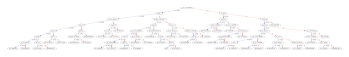

In [0]:
''' XGBoost ''' 
clf = xgb.XGBClassifier(max_depth=7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred, average='macro')

xgb.plot_tree(clf, num_trees=5)
#fig = plt.gcf()
#fig.set_size_inches(150, 100)
#fig.savefig('tree.png')

In [0]:
''' LightGBM '''
clf = lgbm.LGBMClassifier(max_depth=7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred, average='macro')

0.6592130002686005

### Test data cleaning 

In [0]:
test = pd.read_csv('01 Data/test.csv')
test.head()

,id,考區,申請系所
0,0,國立員林崇實高工,逢甲大學應用數學系\n東海大學應用數學系\n逢甲大學工業工程與系統管理學系\n逢甲大學材料科...
1,1,國立臺灣師大附中,逢甲大學應用數學系\n淡江大學數學學系資料科學與數理統計組\n輔仁大學數學系資訊數學組\n國...
2,2,國立臺中二中,逢甲大學應用數學系\n東海大學應用數學系\n東海大學統計學系(自然組)
3,3,高雄市立中山高中,逢甲大學應用數學系\n靜宜大學應用化學系-繁星類
4,4,臺中市立清水高中,逢甲大學應用數學系\n東海大學應用數學系\n中國文化大學化學系


In [0]:
''' Missing values '''
test[test.isnull().values]

''' No. of universities applied ''' 
uni_list = test['申請系所'].str.split('\n')
print('The max no. of uni is ' + str(max(uni_list.str.len()))) 
test['total_uni'] = [round(uni) for uni in uni_list.str.len()]

for i in range(11):
  colname = 'uni_' + str(i)
  test[colname] = 0

for index, value in uni_list.items():
  for n in range(test.loc[index,'total_uni']):
    test.loc[index, 'uni_' + str(n)] = value[n]
test.head(3)

The max no. of uni is 10


,id,考區,申請系所,total_uni,uni_0,uni_1,uni_2,uni_3,uni_4,uni_5,uni_6,uni_7,uni_8,uni_9,uni_10
0,0,國立員林崇實高工,逢甲大學應用數學系\n東海大學應用數學系\n逢甲大學工業工程與系統管理學系\n逢甲大學材料科...,6,逢甲大學應用數學系,東海大學應用數學系,逢甲大學工業工程與系統管理學系,逢甲大學材料科學與工程學系,逢甲大學電機工程學系,逢甲大學資訊電機學院不分系榮譽班,0,0,0,0,0
1,1,國立臺灣師大附中,逢甲大學應用數學系\n淡江大學數學學系資料科學與數理統計組\n輔仁大學數學系資訊數學組\n國...,4,逢甲大學應用數學系,淡江大學數學學系資料科學與數理統計組,輔仁大學數學系資訊數學組,國立東華大學應用數學系統計科學組,0,0,0,0,0,0,0
2,2,國立臺中二中,逢甲大學應用數學系\n東海大學應用數學系\n東海大學統計學系(自然組),3,逢甲大學應用數學系,東海大學應用數學系,東海大學統計學系(自然組),0,0,0,0,0,0,0,0


In [0]:
''' Create high school location column '''
''' https://depart.moe.edu.tw/ed4500/News_Content.aspx?n=63F5AB3D02A8BBAC&sms=1FF9979D10DBF9F3&s=BF61A0C5E5432A0B '''

df_hs = pd.read_csv("01 Data/high.csv")
df_hs = df_hs.iloc[:, [1,3]] #取 [學校名稱]、[縣市名稱]
df_hs['縣市名稱'] = [i[1] for i in df_hs['縣市名稱'].str.split(']')]
df_hs.columns = ['hs', 'hs_state']

''' Handle hs with uni's name ''' 
df_uni = pd.read_csv('01 Data/u1_new.csv')
df_uni = df_uni.iloc[:, [1,3]] #取 [學校名稱]、[縣市名稱]
df_uni['縣市名稱'] = [i[1] for i in df_uni['縣市名稱'].str.split(']')]

uni = []
for i in test['考區']:
  if '大學' in i:
    uni.append(i)
uni = set(uni)

''' Define hs_search function '''
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def hs_search(school, df, colname):
  diff = {}
  for j in df[colname]:
    diff[j] = similar(school, j)
  index_hs = max(diff, key=diff.get)
  return [school, index_hs]

uni_list = []
for u in uni:
  uni_list.append(hs_search(u, df_uni, '學校名稱'))

for u in uni_list:
  test.loc[test['考區']==u[0], '考區'] = u[1]

test['考區'] = test['考區'].str.replace('台', '臺')
test['考區'] = test['考區'].str.replace('?', '內')

for i in test['考區']:
  if '大學' not in i:  
    test.loc[test['考區']==i, '考區'] = i.lstrip('國立')


test['考區'] = test['考區'].str.split('市立').apply(lambda x:x[-1])

test['考區'] = test['考區'].str.replace('私立復旦高中', '桃園市復旦高中')
test['考區'] = test['考區'].str.replace('新莊國中', '新莊高中')
test['考區'] = test['考區'].str.replace('私立道明高中', '天主教道明中學')
test['考區'] = test['考區'].str.replace('彰化師大附屬高工', '彰師附工')
test['考區'] = test['考區'].str.replace('彰化師大附工', '彰師附工')

test['考區'] = test['考區'].str.replace('高雄師大附中', '高師大附中')
test['考區'] = test['考區'].str.replace('桃園農工', '北科大附屬桃園農工')
test['考區'] = test['考區'].str.replace('私立育達高中', '桃園市育達高中')
test['考區'] = test['考區'].str.replace('私立明德女中', '私立明德高中')
test['考區'] = test['考區'].str.replace('華僑高中', '華僑高級中等學校')
# 南新國中 in Tainan not in df_hs dataset but it matches a school in Tainan below

df_hs['hs'] = df_hs['hs'].str.lstrip('國立')
df_hs['hs'] = df_hs['hs'].str.lstrip('市立')

df_uni.columns = ['hs', 'hs_state']
df_hs_uni = pd.concat([df_uni, df_hs], axis=0)

test.columns = ['id', 'hs', '申請系所', 'total_uni', 
                 'uni_0', 'uni_1', 'uni_2', 'uni_3', 'uni_4', 
                 'uni_5', 'uni_6', 'uni_7', 'uni_8', 'uni_9', 'uni_10']

test_merged = pd.merge(test, df_hs_uni, on='hs', how='left', copy=False)
test_merged.drop_duplicates(subset=['id', 'hs', '申請系所'], keep='first', inplace=True) # omit duplicates due to one to many merger 

''' Get unmatched rows and create a df ''' 
df_hs_state = test_merged.filter(items=['hs', 'hs_state'], axis=1)
df_hs_state_na = df_hs_state.loc[df_hs_state.hs_state.isna(), :]

''' Find hs name using hs_search function '''
hs_pair = []
for index in df_hs_state_na.index:
  hs_pair.append(hs_search(df_hs_state_na.loc[index, "hs"], df_hs_uni, "hs"))

''' Insert a hs_new column in df_hs_state ''' 
df_hs_state['hs_new'] = df_hs_state['hs']
for pair in hs_pair:
  df_hs_state.loc[df_hs_state['hs']==pair[0], 'hs_new'] = pair[1]

''' Replace hs column in train_merged w/ hs_new column ''' 
test_merged['hs'] = df_hs_state['hs_new']
test_merged.drop('hs_state', axis=1, inplace=True)

test_merged = pd.merge(test_merged, df_hs_uni, on='hs', how='left', copy=False)
test_merged.drop_duplicates(subset=['id', 'hs', '申請系所'], keep='first', inplace=True)
test_merged.head()

,id,hs,申請系所,total_uni,uni_0,uni_1,uni_2,uni_3,uni_4,uni_5,uni_6,uni_7,uni_8,uni_9,uni_10,hs_state
0,0,員林崇實高工,逢甲大學應用數學系\n東海大學應用數學系\n逢甲大學工業工程與系統管理學系\n逢甲大學材料科...,6,逢甲大學應用數學系,東海大學應用數學系,逢甲大學工業工程與系統管理學系,逢甲大學材料科學與工程學系,逢甲大學電機工程學系,逢甲大學資訊電機學院不分系榮譽班,0,0,0,0,0,彰化縣
1,1,師大附中,逢甲大學應用數學系\n淡江大學數學學系資料科學與數理統計組\n輔仁大學數學系資訊數學組\n國...,4,逢甲大學應用數學系,淡江大學數學學系資料科學與數理統計組,輔仁大學數學系資訊數學組,國立東華大學應用數學系統計科學組,0,0,0,0,0,0,0,臺北市
2,2,臺中二中,逢甲大學應用數學系\n東海大學應用數學系\n東海大學統計學系(自然組),3,逢甲大學應用數學系,東海大學應用數學系,東海大學統計學系(自然組),0,0,0,0,0,0,0,0,臺中市
3,3,中山高中,逢甲大學應用數學系\n靜宜大學應用化學系-繁星類,2,逢甲大學應用數學系,靜宜大學應用化學系-繁星類,0,0,0,0,0,0,0,0,0,高雄市
5,4,清水高中,逢甲大學應用數學系\n東海大學應用數學系\n中國文化大學化學系,3,逢甲大學應用數學系,東海大學應用數學系,中國文化大學化學系,0,0,0,0,0,0,0,0,新北市


In [0]:
test = test_merged

''' No. of public universities enrolled ''' 
public_count = []
for i in test['申請系所']:
  public_count.append(i.count('國立'))
test['no_public'] = public_count

''' Ratio of public universities enrolled '''
test['ratio_public'] = test['no_public']/test['total_uni']

''' No. of FCU degrees enrolled ''' 
fcu_count = []
for i in test['申請系所']:
  fcu_count.append(i.count('逢甲'))
test['no_fcu'] = fcu_count
test.loc[test['no_fcu']==0, 'no_fcu'] = 1

''' Ratio of FCU degrees enrolled '''
test['ratio_fcu'] = test['no_fcu']/test['total_uni']
test.head()

''' No. of math degrees enrolled ''' 
math_count = []
for i in test['申請系所']:
  math_count.append(i.count('數學'))
test['no_math'] = math_count
test.loc[test['no_math']==0, 'no_math'] = 1

''' Ratio of math degrees enrolled '''
test['ratio_math'] = test['no_math']/test['total_uni']

''' HS in Taichung '''
from collections import Counter, defaultdict 
map_state = defaultdict(int)
map_state['臺中市'] = 1
test['taichung'] = test['hs_state'].map(map_state) 

''' HS state engineering '''
test['hs_state'].unique()
state = {'臺中市':0,
         '南投縣':1, '雲林縣':1, '嘉義市':1, '新竹市':1, '新竹縣':1, '彰化縣':1, '苗栗縣':1, 
         '高雄市':2, '臺南市':2, '桃園市':2,
         '基隆市':3, '臺北市':3, '澎湖縣':3, '屏東縣':3, '新北市':3, '臺東縣':3, 
         '宜蘭縣':3, '花蓮縣':3, '金門縣':3}

test['hs_from_taichung'] = test['hs_state'].map(state)
test.head() 

In [0]:
test.to_csv('01 Data/test_clean.csv')

## Prediction 

In [0]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, validation_curve, cross_val_score
from sklearn.metrics import f1_score

import xgboost as xgb
import lightgbm as lgbm

In [46]:
test = pd.read_csv('01 Data/test_add_score.csv', index_col=0)
test['ratio_stat'] = test['no_stat']/test['total_uni']
test = test.filter(items=['total_uni', 'no_public', 'no_fcu', 'no_math', 'taichung',
       'hs_from_taichung', 'ratio_math', 'ratio_fcu', 'ratio_public', 'uni_mean', 
       'ratio_stat', 'distance', 'no_stat'], axis=1)
test.head(1)

,total_uni,no_public,no_fcu,no_math,taichung,hs_from_taichung,ratio_math,ratio_fcu,ratio_public,uni_mean,ratio_stat,distance,no_stat
id,,,,,,,,,,,,,
0,6,0,5,2,0,1,0.333333,0.833333,0.0,277.75,0.0,1,0


In [47]:
train = pd.read_csv('01 Data/train_add_score.csv')
train['ratio_stat'] = train['no_stat']/train['total_uni']
train = train.filter(items=['total_uni', 'no_public', 'no_fcu', 'no_math', 'taichung',
       'hs_from_taichung', 'ratio_math', 'ratio_fcu', 'ratio_public', 'uni_mean', 
       'ratio_stat', 'distance', 'no_stat', 'FCU', 'FCU_AM'], axis=1)
train.head(1)

,total_uni,no_public,no_fcu,no_math,taichung,hs_from_taichung,ratio_math,ratio_fcu,ratio_public,uni_mean,ratio_stat,distance,no_stat,FCU,FCU_AM
0,2,0,1,2,0,1,1.0,0.5,0.0,207.625,0.0,0,0,0,0


In [0]:
X = train[['total_uni', 'no_public', 'no_fcu', 'no_math', 'taichung',
       'hs_from_taichung', 'ratio_math', 'ratio_fcu', 'ratio_public', 'uni_mean', 
       'ratio_stat', 'distance', 'no_stat']]
y = train['FCU']

In [0]:
''' Random Forest Classifier ''' 
''' Hyperparameter Tuning ''' 
# n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, bootstrap 

'''
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 200, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop=9, num = 9)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

clf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X, y)
rf_random.best_params_
'''

param_grid = {
    'bootstrap': [True],
    'max_depth': [1, 2, 3],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [3, 4, 5, 6, 7],
    'n_estimators': [100, 150, 200, 250, 300]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)

In [59]:
model = grid_search.fit(X, y)
model.best_params_

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:  5.8min finished


{'bootstrap': True,
 'max_depth': 2,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 250}

In [52]:
''' LGBM '''
clf = lgbm.LGBMClassifier()

''' Hyperparameter Tuning '''
''' Website: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html ''' 

lgbm_params = {
    'num_leaves': np.random.randint(100, 1000, size=10), #large num leaves 
    'min_data_in_leaves': np.random.randint(10, 100, size=4), #setting it too large may cause underfitting
    'max_depth': np.random.randint(1, 10, size=5),
    'learning_rate': np.linspace(0.01, 0.1, num=5), #small learning rate
}

clf = GridSearchCV(clf, lgbm_params, scoring='f1', cv=5, n_jobs=-1)
model = clf.fit(X, y)

''' LGBM K-fold validation '''
clf = lgbm.LGBMClassifier(learning_rate=0.1,
                          max_depth=2,
                          min_data_in_leaves=84,
                          num_leaves=697)
cross_val_score(clf, X, y, scoring='f1', cv=5, n_jobs=-1)

model.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'min_data_in_leaves': 84,
 'num_leaves': 697}

In [61]:
''' XGBoost '''
clf = xgb.XGBClassifier()

''' Hyperparameter Tuning '''
xgb_params = {
    'max_depth': np.random.randint(1, 10, size=5),
    'learning_rate': np.linspace(0.01, 0.1, num=5), #small learning rate
}

clf = GridSearchCV(clf, xgb_params, scoring='f1', cv=5, n_jobs=-1)
model = clf.fit(X, y)
model.best_params_

{'learning_rate': 0.1, 'max_depth': 1}

In [64]:
clf_1 = RandomForestClassifier(n_estimators=250, max_depth=2, 
                             max_features = 'sqrt', min_samples_leaf = 1,
                             min_samples_split = 5, bootstrap = True)

clf_2 = lgbm.LGBMClassifier(learning_rate=0.1,
                          max_depth=2,
                          min_data_in_leaves=84,
                          num_leaves=697) 

clf_3 = xgb.XGBClassifier(n_estimators=250, learning_rate=0.1,
                          max_depth=1) 

eclf1 = VotingClassifier(estimators=[('rf', clf_1), ('lgbm', clf_2), ('xgb', clf_3)], voting='hard')
eclf1 = eclf1.fit(X, y)

cross_val_score(eclf1, X, y, scoring='f1', cv=5, n_jobs=-1)

array([0.75829384, 0.72300469, 0.71287129, 0.79111111, 0.79425837])

In [66]:
X_test = test[['total_uni', 'no_public', 'no_fcu', 'no_math', 'taichung',
       'hs_from_taichung', 'ratio_math', 'ratio_fcu', 'ratio_public', 'uni_mean', 
       'ratio_stat', 'distance', 'no_stat']]
y_pred = eclf1.predict(X_test)
y_pred

array([1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0])

In [67]:
sub = pd.read_csv('01 Data/sampleSubmission.csv')
sub['FCU'] = y_pred
sub.head()

,id,FCU,FCU_AM
0,0,1,0
1,1,0,0
2,2,1,0
3,3,1,0
4,4,0,0


In [72]:
pd.Series(y_pred).value_counts()

1    206
0     94
dtype: int64

In [77]:
X = train[['total_uni', 'no_public', 'no_fcu', 'no_math', 'taichung',
       'hs_from_taichung', 'ratio_math', 'ratio_fcu', 'ratio_public', 'uni_mean', 
       'ratio_stat', 'distance', 'no_stat', 'FCU']]
y = train['FCU_AM']

clf_1 = RandomForestClassifier(n_estimators=250, max_depth=2, 
                             max_features = 'sqrt', min_samples_leaf = 1,
                             min_samples_split = 5, bootstrap = True)

clf_2 = lgbm.LGBMClassifier(learning_rate=0.1,
                          max_depth=2,
                          min_data_in_leaves=84,
                          num_leaves=697) 

clf_3 = xgb.XGBClassifier(n_estimators=250, learning_rate=0.1,
                          max_depth=1) 

eclf1 = VotingClassifier(estimators=[('rf', clf_1), ('lgbm', clf_2), ('xgb', clf_3)], voting='hard')
eclf1 = eclf1.fit(X, y)

cross_val_score(eclf1, X, y, scoring='f1', cv=5, n_jobs=-1)

array([0.8427673 , 0.86486486, 0.87417219, 0.83211679, 0.86896552])

In [79]:
X_test = test[['total_uni', 'no_public', 'no_fcu', 'no_math', 'taichung',
       'hs_from_taichung', 'ratio_math', 'ratio_fcu', 'ratio_public', 'uni_mean', 
       'ratio_stat', 'distance', 'no_stat']]
X_test['FCU'] = y_pred
y_pred = eclf1.predict(X_test)
y_pred

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0])

In [80]:
sub['FCU_AM'] = y_pred
sub.head()

,id,FCU,FCU_AM
0,0,1,0
1,1,0,0
2,2,1,1
3,3,1,1
4,4,0,0


In [81]:
sub.loc[(sub['FCU']==0) & (sub['FCU_AM']==1), :]

,id,FCU,FCU_AM


In [0]:
sub.to_csv('01 Data/submission_elf_2nd.csv', index=False)